<a href="https://colab.research.google.com/github/malloyca/steelpan-pitch/blob/main/onset-pitch/steelpan_onset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steelpan Onset-based Pitch Detection

For 183rd Meeting of the Acoustical Society of America, December 8, 2022.

In [3]:
!pip install crepe
import crepe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
!pip install essentia
import essentia.standard as es

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.6 MB 21.3 MB/s 


In [4]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display

print(f"TensorFlow version: {tf.__version__}")

physical_devices = tf.config.list_physical_devices()
print(physical_devices)

TensorFlow version: 2.9.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
# download the SASSE dataset # TODO: update dataset to newer version
#!gdown 1hRfdF0ko2ItGK0y9z4xU_7VQLgRIx4Ql
#!unzip -u -qq '/content/SASSE_tiny_16.zip'

In [6]:
# download the SASSE-16k dataset
!gdown 11volHbUTp1X0NyrtiEgjRtgwivwaw1Bs
!unzip -u -qq '/content/SASSE_16.zip'

Downloading...
From: https://drive.google.com/uc?id=11volHbUTp1X0NyrtiEgjRtgwivwaw1Bs
To: /content/SASSE_16.zip
100% 443M/443M [00:02<00:00, 178MB/s]


In [7]:
# download the SASSE-48k dataset
!gdown 1U3IfVjQ_xCc7ZqVZpR9oPNAtPfA26CKs
!unzip -u -qq '/content/SASSE_48.zip'

Downloading...
From: https://drive.google.com/uc?id=1U3IfVjQ_xCc7ZqVZpR9oPNAtPfA26CKs
To: /content/SASSE_48.zip
100% 1.10G/1.10G [00:07<00:00, 138MB/s]


# Steelpan Note Transients

Let's begin by examining the attack transients of a few steelpan samples.

In [53]:
frame_length = 2048
sr = 22050
attack_time = es.LogAttackTime(sampleRate=sr, startAttackThreshold=0.1, stopAttackThreshold=0.95)

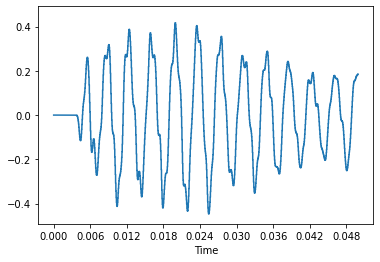

In [54]:
audio_01, sr = librosa.load('/content/SASSE_48/validation/60_valid_sample_7.wav')

lat, attack_start, attack_stop = attack_time(audio_01)
start, stop = int(sr * attack_start), int(sr * attack_stop)

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_01[:int(0.05*sr)], sr=sr, ax=ax)
plt.show()

Attack length: 15.011338517069817 ms
Number of samples: 331


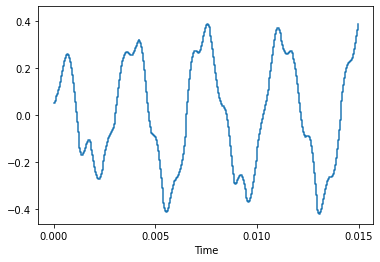

In [55]:
print(f"Attack length: {(attack_stop - attack_start) * 1000} ms")
print(f"Number of samples: {int((attack_stop - attack_start)*sr)}")
fig, ax = plt.subplots()
librosa.display.waveshow(audio_01[int(attack_start * sr) : int(attack_stop * sr)])
plt.show()

In [56]:
audio = audio_01

yin_out = librosa.yin(audio[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(f"50 ms: {np.round(yin_out,2)}")

yin_out = librosa.yin(audio[start:stop], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(f"attack predictions: {np.round(yin_out, 2)}")

50 ms: [60.68 60.91 60.68 60.43 60.42]
attack predictions: [48.3]


In [57]:
audio = audio_01

pyin_out, _, _ = librosa.pyin(audio[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(f"50ms: {pyin_out}")

pyin_out, _, _ = librosa.pyin(audio[start:stop], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(f"attack: {pyin_out}")

50ms: [ nan 60.9 60.7 60.4 60.4]
attack: [nan]


In [59]:
audio = audio_01

time, crepe_pred, _, _ = crepe.predict(audio, sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(f"50 ms: {np.round(crepe_pred,2)}")

time, crepe_pred, _, _ = crepe.predict(audio[start:stop], sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(f"attack: {np.round(crepe_pred,2)}")

8/8 [==============================] - 12s 1s/step
50 ms: [60.65 60.51 60.46 60.42 60.32 60.36 60.46 60.46 60.4  60.27 60.18 60.16
 60.14 60.12 60.14 60.15 60.14 60.12 60.09 60.08 60.09 60.11 60.13 60.13
 60.12 60.09 60.09 60.09 60.11 60.11 60.11 60.11 60.09 60.06 60.07 60.09
 60.09 60.09 60.08 60.08 60.07 60.08 60.08 60.1  60.08 60.08 60.07 60.07
 60.08 60.09 60.1  60.09 60.08 60.07 60.07 60.07 60.11 60.12 60.12 60.1
 60.08 60.08 60.08 60.08 60.09 60.08 60.06 60.07 60.07 60.08 60.08 60.08
 60.07 60.07 60.06 60.07 60.08 60.09 60.07 60.06 60.07 60.07 60.06 60.08
 60.08 60.07 60.06 60.06 60.07 60.08 60.07 60.06 60.07 60.06 60.07 60.08
 60.1  60.08 60.07 60.07 60.07 60.07 60.09 60.09 60.1  60.07 60.06 60.07
 60.09 60.08 60.09 60.08 60.07 60.09 60.1  60.1  60.08 60.07 60.07 60.08
 60.07 60.09 60.08 60.07 60.07 60.07 60.06 60.06 60.07 60.1  60.08 60.07
 60.07 60.07 60.09 60.09 60.06 60.07 60.08 60.1  60.1  60.09 60.1  60.09
 60.07 60.07 60.07 60.07 60.1  60.12 60.11 60.08 60.05 60.05 60.07 

### What this shows

What the tests show for performing this on just the attack portion as determined by Essentia is that accuracy on such a small section is difficult and the algorithms clearly rely on longer contexts for accuracy.

8/8 [==============================] - 14s 2s/step
50 ms: [55.62 55.53 54.5  53.96 53.08 52.62 52.06 51.4  50.87 50.03 48.38 47.3
 47.77 47.66 47.98 47.92 47.78 47.63 49.17 50.85 51.99 53.65 54.85 54.88
 54.93 54.88 54.92 55.02 56.5  56.3  56.66 57.98 59.65 59.88 59.72 59.46
 59.37 59.81 60.16 60.17 60.15 60.07 60.28 60.01 59.71 59.79 59.91 60.01
 60.08 60.07 60.02 60.03 59.99 60.06 60.02 59.98 60.08 60.12 60.08 60.01
 59.98 60.01 60.02 60.   59.95 60.1  60.27 60.36 60.27 60.09 60.01 59.98
 60.03 60.05 60.11 60.15 60.11 60.11 60.08 60.07 60.04 60.02 60.04 60.07
 60.09 60.11 60.1  60.07 60.05 60.06 60.06 60.07 60.07 60.07 60.08 60.08
 60.07 60.06 60.05 60.07 60.06 60.05 60.05 60.06 60.07 60.08 60.06 60.05
 60.04 60.05 60.06 60.06 60.07 60.07 60.07 60.07 60.06 60.04 60.08 60.08
 60.1  60.08 60.08 60.06 60.08 60.06 60.08 60.06 60.06 60.05 60.06 60.07
 60.07 60.06 60.06 60.05 60.05 60.06 60.07 60.06 60.06 60.05 60.06 60.05
 60.06 60.06 60.05 60.05 60.05 60.05 60.06 60.06 60.06 60.06 60.05 

/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)


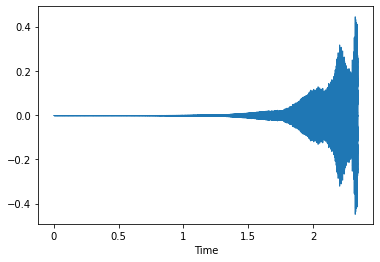

In [67]:
audio_rev = audio[::-1]

time, crepe_pred, _, _ = crepe.predict(audio_rev, sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(f"50 ms: {np.round(crepe_pred,2)}")

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_rev, sr=sr, ax=ax)
plt.show()

### Thoughts on bi-directional analysis

Interestingly, what this cell shows is that doing pitch detection in reverse gives different results. My intuition is that this could be caused by one of two things:
1. You are just catching the audio at different points. This would be similar to changing the start point of the analysis.
  - I'm leaning against this, however, since you'd think that the results would still be similar. The beginnings and endings of the two prediction arrays vary quite a bit, however. This leads me to my second hypothesis:
2. That since this is probabilistic (it uses the Viterbi algorithm) - and thus dependent on previous predictions - the direction of the processing affects the output values. The question then becomes, can we improve pitch detection results by performing bi-directional analysis?
  - An initial test of this would be to analyze an annotated dataset both forwards and backwards and then combining/averaging that data somehow. Another intersting approach would be to build a pitch detection architecture that does the bi-directional analysis by default.
  - The unfortunate limitation of this method would be that it really only works for offline analysis.

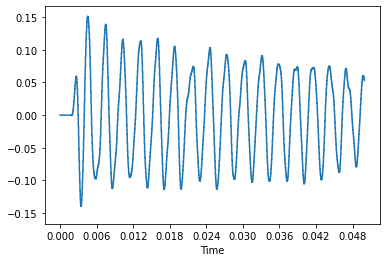

In [13]:
audio_02, sr = librosa.load('/content/SASSE_48/validation/65_valid_sample_33.wav')

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_02[:int(0.05*sr)], sr=sr, ax=ax)
plt.show()

In [14]:
yin_out = librosa.yin(audio_02[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(np.round(yin_out,2))

[65.26 65.33 65.25 65.1  65.01]


In [15]:
pyin_out, _, _ = librosa.pyin(audio_02[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(pyin_out)

[ nan 65.3 65.2 65.1 65. ]


In [16]:
time, crepe_pred, _, _ = crepe.predict(audio_02[:frame_length], sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(np.round(crepe_pred,2))

1/1 [==============================] - 0s 494ms/step
[65.04 65.02 65.07 65.04 64.99 65.01 65.01 65.   65.   64.98]


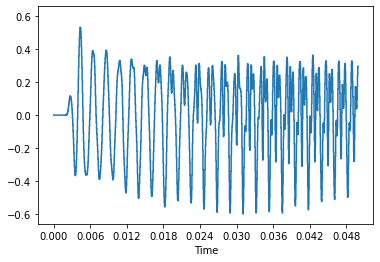

In [17]:
audio_03, sr = librosa.load('/content/SASSE_48/validation/70_valid_sample_86.wav')

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_03[:int(0.05*sr)], sr=sr, ax=ax)
plt.show()

In [18]:
yin_out = librosa.yin(audio_03[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(np.round(yin_out,2))

[70.06 70.17 70.06 70.05 70.06]


In [19]:
pyin_out, _, _ = librosa.pyin(audio_03[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(pyin_out)

[ nan 70.2 70.1 70.  70.1]


In [20]:
time, crepe_pred, _, _ = crepe.predict(audio_03[:frame_length], sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(np.round(crepe_pred,2))

1/1 [==============================] - 1s 514ms/step
[70.07 70.03 70.03 70.05 70.04 70.05 70.05 70.03 70.   70.  ]


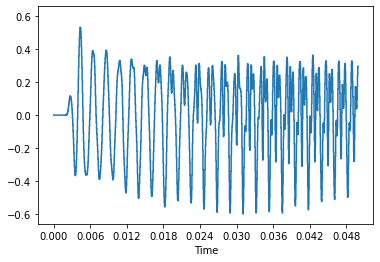

In [21]:
audio_04, sr = librosa.load('/content/SASSE_48/validation/71_valid_sample_19.wav')

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_03[:int(0.05*sr)], sr=sr, ax=ax)
plt.show()

In [22]:
yin_out = librosa.yin(audio_04[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(np.round(yin_out,2))

[71.15 71.26 71.14 71.06 71.07]


In [23]:
pyin_out, _, _ = librosa.pyin(audio_04[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(pyin_out)

[ nan 71.3 71.1 71.1 71.1]


In [24]:
time, crepe_pred, _, _ = crepe.predict(audio_04[:frame_length], sr, viterbi=True)
crepe_pred = librosa.hz_to_midi(crepe_pred)
print(np.round(crepe_pred,2))

1/1 [==============================] - 0s 490ms/step
[71.24 71.13 71.11 71.08 71.06 71.06 71.04 71.03 71.02 71.03]


# Evaluating Yin, pYin, and CRéPE

## pYin evaluation

In [ ]:
def get_pyin_estimation(sample_path, samplerate, attack_length):

  # load sample
  loader = es.MonoLoader(filename=sample_path, sampleRate=samplerate)
  audio = loader()

  # trim the sample to the first 50
  start_stop = es.StartStopsi

# CRéPE-style network

## Model Builder

In [ ]:
models = {
    'tiny': None,
    'small': None,
    'medium': None,
    'large': None,
    'full': None
}

# the model is trained on 16 kHz audio for now # TODO: upgrade to a higher samplerate
model_samplerate = 1600

def make_model(model_capacity, metrics, weights=None):
  '''
  model_capacity: tiny, small, medium, large, full
  weights: path of .h5 weight file
  '''

  from tensorflow.keras.layers import Input, Reshape, Conv2D, BatchNormalization
  from tensorflow.keras.layers import MaxPool2D, Dropout, Permute, Flatten, Dense
  from tensorflow.keras.models import Model

  capacity_multiplier = {
      'tiny': 4, 'small': 8, 'medium': 16, 'large': 24, 'full': 32
  }(model_capacity)

  layers = [1, 2, 3, 4, 5, 6]
  filters = [n * capacity_multiplier for n in [32, 4, 4, 4, 8, 16]]
  widths = [512, 64, 64, 64, 64, 64]
  strides = [(4,1), (1,1), (1,1), (1,1), (1,1), (1,1)]

  x = Input(shape=(1024,), name='input', dtype='float32')
  y = Reshape(target_shape=(1024, 1, 1), name='input-reshape')(x)

  for l, f, w, s in zip(layers, filters, widths, strides):
    y = Conv2d(f, (w, 1), strides=s, padding='same',
               activation='relu', name="conv%d" % l)(y)
    y = BatchNormalization(name="conv%d-BN" % l)(y)
    y = MaxPool2D(pool_size=(2, 1), strides=None, padding='valid',
                  name="conv%d-maxpool" % l)(y)
    y = Dropout(0.25, name="conv%d-dropout" % l)(y)

  y = Permute((2, 1, 3), name="transpose")(y)
  y = Flatten(name="flatten")(y)
  y = Dense(360, activation='sigmoid', name="classifier")(y)

  model = Model(inputs=x, outputs=y)

  if weights != None:
    model.load_weights(weights)
  model.compile(tf.keras.optimizers.Adam(learning_rate=0.0002),
                'binary_crossentropy', metrics=metrics)
  
  models[model_capacity] = model

  return model

In [ ]:
# todo - Just use Librosa's db_to_power instead?
def db_to_pow(db):
  '''Convert from dB to power'''
  return 10**(db / 10)


def frame_energy(frame):
  '''Calculates the average energy for a frame
    
    Parameters
    ----------
    frame : np.array
      audio frame in np.float32 format

    Returns
    -------
    average_energy : float
      Average energy level for frame
  '''

  # Square the sample values to convert to energy values
  energy = frame**2

  # Sum the energy values to get total energy
  total_energy = np.sum(energy)

  # Divide by length to get average energy
  return total_energy / len(frame)

In [ ]:
make_model(_, _)